## DreamBooth on Stable Diffusion 2.1

DreamBooth is a powerful technique for personalizing latent diffusion models, such as Stable Diffusion, allowing the model to be fine-tuned to generate specific images based on a limited set of data.

### Step 0: Environment configuration

This command installs the "diffusers" library directly from the Hugging Face GitHub repository.The diffusers library is used to work with latent diffusion models, such as Stable Diffusion, and provides tools for image generation, fine-tuning, and other functionalities.


In [1]:
!pip install -r ../requirements.txt --quiet

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      [WARNING] Unable to import torch, pre-compiling ops will be disabled. Please visit https://pytorch.org/ to see how to properly install torch on your system.
       [WARNING]  unable to import torch, please install it if you want to pre-compile any deepspeed ops.
      DS_BUILD_OPS=1
      Traceback (most recent call last):
        File "C:\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_f

### Configuration and Secrets Loading
In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like Galileo and HuggingFace


In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.utils import (
    load_config_and_secrets,
    configure_proxy,
    setup_galileo_environment,
)

from core.custom_metrics.image_metrics_scorers import entropy_scorer, complexity_scorer, set_custom_image_path
from core.deploy.deploy_image_generation import deploy_model
from core.local_inference.inference import StableDiffusionPipelineOutput, load_config, run_inference
from core.dreambooth_inference.inference_dreambooth import StableDiffusionPipelineOutput, load_config_dreambooth, run_inference_dreambooth



from huggingface_hub import snapshot_download
import promptquality as pq
import glob

2025-05-14 10:06:16.142564: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 10:06:16.431807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747217176.542108    1107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747217176.574498    1107 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747217176.775461    1107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
CONFIG_PATH = "../../configs/config.yaml"
SECRETS_PATH = "../../configs/secrets.yaml"

config, secrets = load_config_and_secrets(CONFIG_PATH, SECRETS_PATH)

In [4]:
configure_proxy(config)

### Download model local

This code imports the snapshot_download function from the huggingface_hub library to download the latest version of the "stabilityai/stable-diffusion-2-1" model. It sets a local directory for saving the model (local_model_path), and the download is configured to be resumable in case it is interrupted, with an etag timeout set to 60 seconds.

In [4]:
# Download the snapshot directly to the local directory
local_model_path = os.path.join("..", "..", "..", "local", "stable-diffusion-2-1")

# Downloading the latest revision of the "stabilityai/stable-diffusion-2-1" model
snapshot_download(
    repo_id="stabilityai/stable-diffusion-2-1", 
    local_dir=local_model_path,
    resume_download=True,
    etag_timeout=60  
)

/opt/conda/lib/python3.12/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

'/home/jovyan/local/stable-diffusion-2-1'

### Step 1: Load the Model
We load the pre-trained Stable Diffusion 2.1 model from Hugging Face and move it to the GPU for efficient execution

Detected 1 GPU, using config/default_config_one-gpu.yaml
GPU 0: 29GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean ../../../local/stable-diffusion-2-1/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


  0%|          | 0/60 [00:00<?, ?it/s]

Average Inference Time: 8.98 seconds
Median Inference Time: 8.98 seconds
Min Inference Time: 8.98 seconds
Max Inference Time: 8.98 seconds


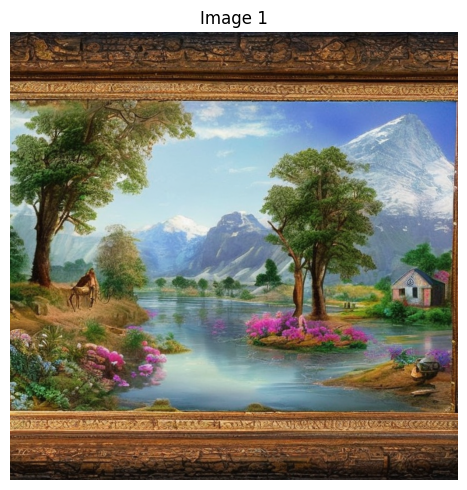

In [5]:
config = load_config()

run_inference(
    prompt="A beautiful landscape",
    height=768,
    width=768,
    num_images=1,
    num_inference_steps=60,
    output=True  
)



## Step 3: Training Dreambooth

This Bash script checks the available GPUs using PyTorch, selects a multi-GPU or single-GPU configuration file accordingly, and then launches a training script (using accelerate) for Dreambooth on Stable Diffusion with specified parameters. It also records and calculates the training duration.

In [6]:
%%bash
NUM_GPUS=$(python3 -c "import torch; print(torch.cuda.device_count())")

if [ "$NUM_GPUS" -ge 2 ]; then
  CONFIG_FILE="config/default_config_multi-gpu.yaml"
  echo "Detected $NUM_GPUS GPUs, using $CONFIG_FILE"
else
  CONFIG_FILE="config/default_config_one-gpu.yaml"
  echo "Detected $NUM_GPUS GPU, using $CONFIG_FILE"
fi

START=$(date +%s)

accelerate launch --config_file $CONFIG_FILE core/train/train_dreambooth_aistudio.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1"  \
  --instance_data_dir="../data/img" \
  --output_dir="./dreambooth/" \
  --instance_prompt="A modern laptop on a sandy beach with the ocean in the background, sunlight reflecting off the screen" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=400 \
  --logging_dir="/phoenix/tensorboard/tensorlogs" \
  --report_to="tensorboard" \
  --validation_prompt="A photo of an HP laptop on the sand with a sunset over the ocean in the background." \
  --num_validation_images=1 \
  --validation_steps=100

END=$(date +%s)
DIFF=$(( $END - $START ))


Detected 1 GPU, using config/default_config_one-gpu.yaml


2025-05-13 18:37:40.639875: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 18:37:40.655531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747161460.674744    1385 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747161460.680614    1385 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747161460.695633    1385 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[2025-05-13 18:39:35,137] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /home/jovyan/.triton/autotune: No such file or directory
05/13/2025 18:39:38 - INFO - __main__ - ***** Running training *****
05/13/2025 18:39:38 - INFO - __main__ -   Num examples = 4
05/13/2025 18:39:38 - INFO - __main__ -   Num batches each epoch = 4
05/13/2025 18:39:38 - INFO - __main__ -   Num Epochs = 100
05/13/2025 18:39:38 - INFO - __main__ -   Instantaneous batch size per device = 1
05/13/2025 18:39:38 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 1
05/13/2025 18:39:38 - INFO - __main__ -   Gradient Accumulation steps = 1
05/13/2025 18:39:38 - INFO - __main__ -   Total optimization steps = 400
05/13/2025 18:39:38 - INFO - __main__ - Checking validation condition: step 0, validation every 100 steps
Steps:  25%|██▌       | 100/400 [00:58<02:53,  1.73it/s, loss=0.0742, lr=5e-6]05/13/2025 18:40:37 - INFO - __main__ - Running validation at step 100.
05/13/2025 18:40:37 - INFO - __main__ - Starting validation process.
05/13/2025 18:40:3

## Inference Local Model

This code imports functions from the inference_dreambooth module, loads a configuration, and then runs inference to generate images. It uses a prompt to create three images with a resolution of 768x768 pixels, executing 100 inference steps per image.

Detected 1 GPU, using config/default_config_one-gpu.yaml
GPU 0: 29GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Average Inference Time: 13.60 seconds
Median Inference Time: 13.43 seconds
Min Inference Time: 13.26 seconds
Max Inference Time: 14.12 seconds


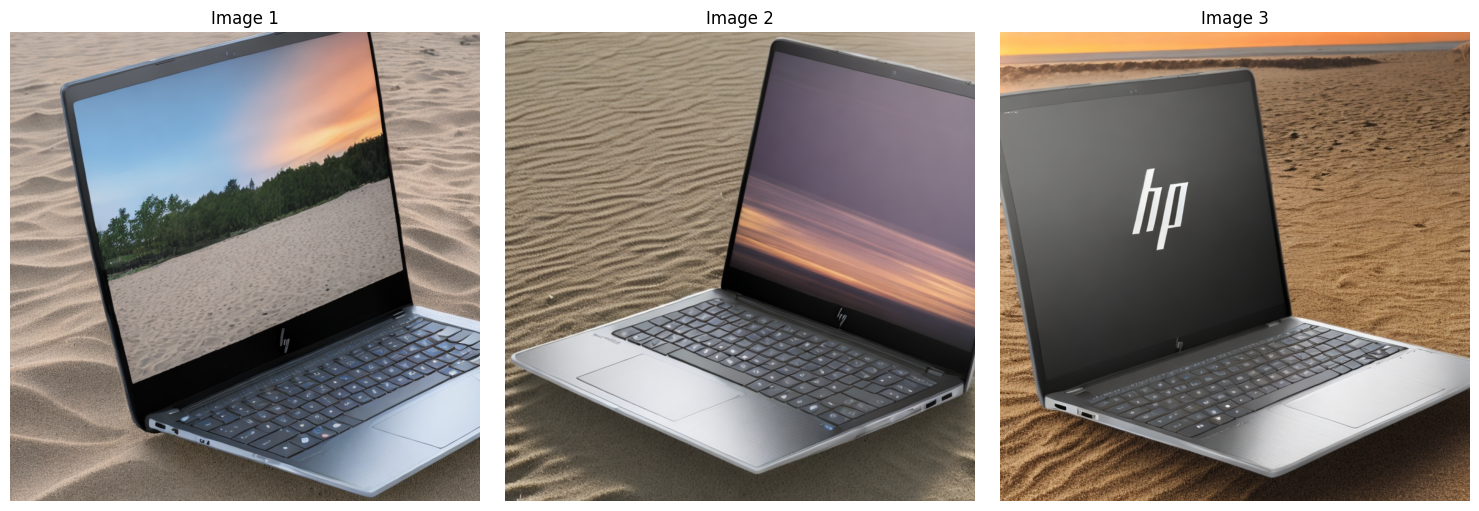

In [5]:
config = load_config_dreambooth()

run_inference_dreambooth(
    prompt="A high-quality photo of an HP laptop placed on the sand at the beach, with a sunset over the ocean in the background.", 
    height=768, 
    width=768, 
    num_images=3, 
    num_inference_steps=100,
    output=True
)


## Galileo Evaluate Custom metrics
Galileo GenAI Studio supports Custom Metrics (programmatic or GPT-based) for all your Evaluate and Observe projects. 

In [6]:
#########################################
# In order to connect to Galileo, create a secrets.yaml file in the configs folder.
# This file should be an entry called GALILEO_API_KEY, with your personal Galileo API Key
# Galileo API keys can be created on https://console.hp.galileocloud.io/settings/api-keys
#########################################

setup_galileo_environment(secrets)
pq.login(os.environ['GALILEO_CONSOLE_URL'])

👋 You have logged into 🔭 Galileo (https://console.hp.galileocloud.io/) as diogo.vieira@hp.com.


Config(console_url=HttpUrl('https://console.hp.galileocloud.io/'), username=None, password=None, api_key=SecretStr('**********'), token=SecretStr('**********'), current_user='diogo.vieira@hp.com', current_project_id=None, current_project_name=None, current_run_id=None, current_run_name=None, current_run_url=None, current_run_task_type=None, current_template_id=None, current_template_name=None, current_template_version_id=None, current_template_version=None, current_template=None, current_dataset_id=None, current_job_id=None, current_prompt_optimization_job_id=None, api_url=HttpUrl('https://api.hp.galileocloud.io/'))

In [8]:

#########################################

# Returns the path of the most recent image that matches the specified pattern.

#########################################

def get_latest_generated_image(directory: str = "./", prefix: str = "local_model_result_", ext: str = ".png") -> str:
    files = glob.glob(os.path.join(directory, f"{prefix}*{ext}"))
    if not files:
        raise FileNotFoundError("No generated images found.")
    latest_file = max(files, key=os.path.getmtime)
    return latest_file

Detected 1 GPU, using config/default_config_one-gpu.yaml
GPU 0: 29GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Average Inference Time: 13.69 seconds
Median Inference Time: 13.69 seconds
Min Inference Time: 13.69 seconds
Max Inference Time: 13.69 seconds


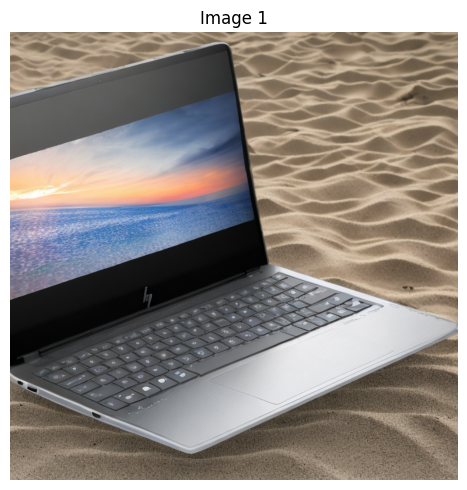

[set_custom_image_path] CUSTOM_IMAGE_PATH atualizado para: ./local_model_result_0.png


Generating responses with openai...:   0%|          | 0/8 [00:00<?, ?it/s]

Initial job complete, executing scorers asynchronously. Current status:
cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
latency: Done ✅
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/0d04650b-3b29-4d44-b674-a28fab4050bc/418d4949-bff6-4926-8b6e-b7d4b104ae2b?taskType=7
[executor_entropy] Using image_path: ./local_model_result_0.png
[load_image] Loading the image of: ./local_model_result_0.png
[load_image] Image loaded with shape: (768, 768, 3), dtype: float32
[convert_to_grayscale] Image converted to grayscale. Shape: (768, 768)
[shannon_entropy_np] Entropia calculada: -88.88248100203006
[executor_entropy] Entropy: -88.88248100203006
[executor_complexity] Using image_path: ./local_model_result_0.png
[load_image] Loading the image of: ./local_model_result_0.png
[load_image] Image loaded with shape: (768, 768, 3), dtype: float32
[convert_to_grayscale] Image converted to grayscale. Shape: (768, 768)
[calculate_complexity] Complex

In [9]:

config = load_config_dreambooth()

prompt_text = ("A high-quality photo of an HP laptop placed on the sand at the beach, "
               "with a sunset over the ocean in the background.")

run_inference_dreambooth(
    prompt=prompt_text, 
    height=768, 
    width=768, 
    num_images=1, 
    num_inference_steps=100,
    output=True
)

generated_image_path = get_latest_generated_image()

set_custom_image_path(generated_image_path)

template = prompt_text

result_custom = pq.run(template=template, scorers=[entropy_scorer, complexity_scorer])
print("Result:", result_custom)

## Model Service

Using MLflow, we will save and load the model in an integrated manner, enabling the traceability and reproducibility of experiments. MLflow will facilitate model versioning, monitoring, and deployment, ensuring a robust pipeline for your project.

In [ ]:
deploy_model()